In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


False
None


In [6]:
!pip install tonic --quiet
!pip install --upgrade pip

In [8]:
import tonic
import torchvision

sensor_size = tonic.datasets.POKERDVS.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=1000)

trainset = tonic.datasets.POKERDVS(save_to="./data", train=True)
testset = tonic.datasets.POKERDVS(
    save_to="./data", transform=frame_transform, train=False
)

In [10]:
events = trainset[0][0]
events

array([(    0,  5,  3, 1), (   89, 28,  3, 1), (   97,  5,  5, 1), ...,
       (24795,  3, 21, 1), (24796, 18, 30, 1), (24797, 10, 20, 1)],
      dtype=[('t', '<i8'), ('x', '<i8'), ('y', '<i8'), ('p', '<i8')])

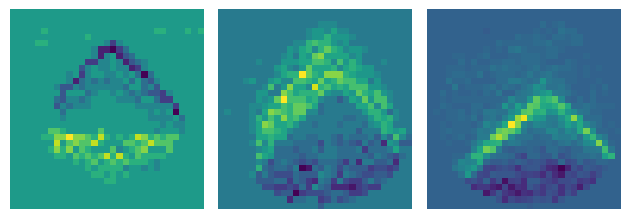

In [12]:
tonic.utils.plot_event_grid(events)

In [14]:
trainset[0][1]

3

In [16]:
# reduce this number if you run out of GPU memory
BATCH_SIZE = 32

# add sparse transform to trainset, previously omitted because we wanted to look at raw events
trainset.transform = frame_transform

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=False,
)

In [18]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self,
        input_features,
        hidden_features,
        output_features,
        tau_syn_inv,
        tau_mem_inv,
        record=False,
        dt=1e-3,
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(
                alpha=100,
                v_th=torch.as_tensor(0.3),
                tau_syn_inv=tau_syn_inv,
                tau_mem_inv=tau_mem_inv,
            ),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFState'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFFeedForwardState'> is a subclass of `collections.namedtuple`, which is al

In [19]:
example_snn = SNN(
    np.product(trainset.sensor_size),
    100,
    len(trainset.classes),
    tau_syn_inv=torch.tensor(1 / 1e-2),
    tau_mem_inv=torch.tensor(1 / 1e-2),
    record=True,
    dt=1e-3,
)

frames, target = next(iter(train_loader))

frames[:, :1].shape

torch.Size([29, 1, 2, 35, 35])

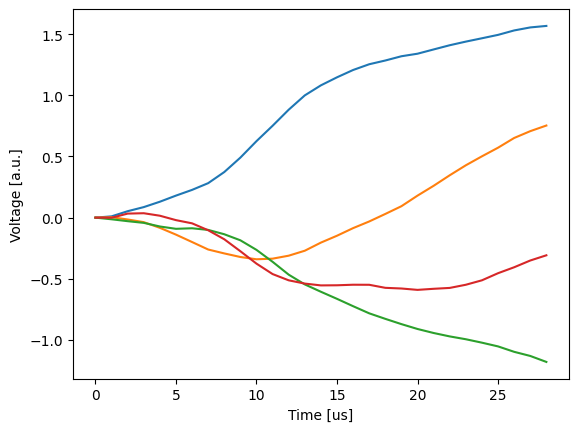

In [22]:
example_readout_voltages = example_snn(frames[:, :1])
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [us]")
plt.show()

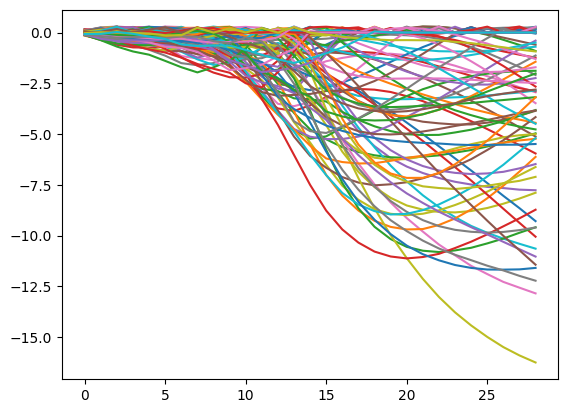

In [24]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

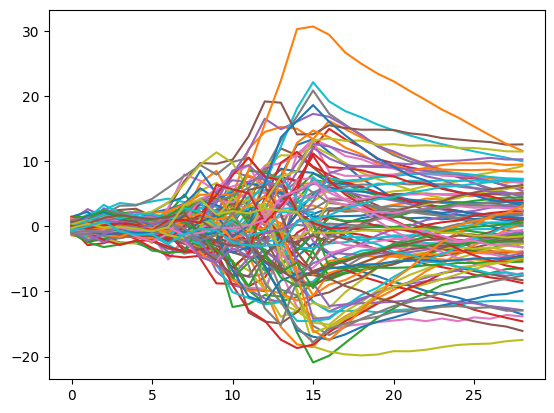

In [26]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

In [28]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y


class Model(torch.nn.Module):
    def __init__(self, snn, decoder):
        super(Model, self).__init__()
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [30]:
LR = 0.002
INPUT_FEATURES = np.product(trainset.sensor_size)
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = len(trainset.classes)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
        tau_syn_inv=torch.tensor(1 / 1e-2),
        tau_mem_inv=torch.tensor(1 / 1e-2),
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=2450, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(100.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.3000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=4, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [32]:
from tqdm.notebook import tqdm, trange


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), torch.LongTensor(target).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [34]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), torch.LongTensor(target).to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [49]:
from torch.utils.data import random_split, DataLoader

# Aufteilen des Trainingsdatensatzes in Trainings- und Validierungsdatensatz
val_size = int(0.2 * len(trainset))  # 20% für Validierung
train_size = len(trainset) - val_size
trainset, val_data = random_split(trainset, [train_size, val_size])

# DataLoader für den Validierungsdatensatz
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100.0 * correct / len(val_loader.dataset)

    return val_loss, accuracy


In [53]:
val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),  # Hinzufügen von Padding
    shuffle=False,
)


In [55]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []
validation_losses = []
validation_accuracies = []
EPOCHS= 100
for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, EPOCHS
    )
    
    # Test
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model, DEVICE, val_loader)
    
    # Update der Metriken
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    # Falls NaN oder unendlicher Verlust erkannt wurde, breche das Training ab
    if mean_loss == 0.0 or test_loss == 0.0 or val_loss == 0.0:
        print("Training wegen NaN oder unendlichem Verlust abgebrochen.")
        break

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {mean_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.9628, Test Loss: 0.9781, Validation Loss: 1.1011, Accuracy: 50.00%, Validation Accuracy: 44.44%
Epoch 2/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 0.7812, Test Loss: 0.9503, Validation Loss: 1.0462, Accuracy: 55.00%, Validation Accuracy: 44.44%
Epoch 3/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 0.8310, Test Loss: 0.9123, Validation Loss: 0.9803, Accuracy: 60.00%, Validation Accuracy: 44.44%
Epoch 4/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 0.8097, Test Loss: 0.8811, Validation Loss: 0.9407, Accuracy: 60.00%, Validation Accuracy: 44.44%
Epoch 5/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 0.7439, Test Loss: 0.8578, Validation Loss: 0.8944, Accuracy: 60.00%, Validation Accuracy: 44.44%
Epoch 6/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 0.7847, Test Loss: 0.8426, Validation Loss: 0.8646, Accuracy: 60.00%, Validation Accuracy: 66.67%
Epoch 7/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 0.7559, Test Loss: 0.8289, Validation Loss: 0.8420, Accuracy: 60.00%, Validation Accuracy: 66.67%
Epoch 8/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 0.7089, Test Loss: 0.8077, Validation Loss: 0.8216, Accuracy: 60.00%, Validation Accuracy: 66.67%
Epoch 9/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 0.7283, Test Loss: 0.7916, Validation Loss: 0.8114, Accuracy: 60.00%, Validation Accuracy: 66.67%
Epoch 10/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.6520, Test Loss: 0.7807, Validation Loss: 0.8010, Accuracy: 55.00%, Validation Accuracy: 66.67%
Epoch 11/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 0.6906, Test Loss: 0.7746, Validation Loss: 0.7947, Accuracy: 55.00%, Validation Accuracy: 66.67%
Epoch 12/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 0.7709, Test Loss: 0.7681, Validation Loss: 0.7886, Accuracy: 55.00%, Validation Accuracy: 77.78%
Epoch 13/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 0.7469, Test Loss: 0.7665, Validation Loss: 0.7868, Accuracy: 55.00%, Validation Accuracy: 66.67%
Epoch 14/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 0.6584, Test Loss: 0.7617, Validation Loss: 0.7841, Accuracy: 55.00%, Validation Accuracy: 77.78%
Epoch 15/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 0.7441, Test Loss: 0.7537, Validation Loss: 0.7825, Accuracy: 55.00%, Validation Accuracy: 77.78%
Epoch 16/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 0.7198, Test Loss: 0.7575, Validation Loss: 0.7809, Accuracy: 55.00%, Validation Accuracy: 77.78%
Epoch 17/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 0.7182, Test Loss: 0.7568, Validation Loss: 0.7789, Accuracy: 55.00%, Validation Accuracy: 77.78%
Epoch 18/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 0.6739, Test Loss: 0.7590, Validation Loss: 0.7774, Accuracy: 55.00%, Validation Accuracy: 88.89%
Epoch 19/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 0.6725, Test Loss: 0.7615, Validation Loss: 0.7763, Accuracy: 55.00%, Validation Accuracy: 77.78%
Epoch 20/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.6496, Test Loss: 0.7610, Validation Loss: 0.7757, Accuracy: 55.00%, Validation Accuracy: 77.78%
Epoch 21/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 0.7355, Test Loss: 0.7651, Validation Loss: 0.7745, Accuracy: 55.00%, Validation Accuracy: 88.89%
Epoch 22/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 0.6707, Test Loss: 0.7633, Validation Loss: 0.7738, Accuracy: 55.00%, Validation Accuracy: 88.89%
Epoch 23/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 0.7130, Test Loss: 0.7580, Validation Loss: 0.7728, Accuracy: 55.00%, Validation Accuracy: 88.89%
Epoch 24/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 0.7320, Test Loss: 0.7608, Validation Loss: 0.7721, Accuracy: 55.00%, Validation Accuracy: 88.89%
Epoch 25/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 0.6885, Test Loss: 0.7610, Validation Loss: 0.7715, Accuracy: 55.00%, Validation Accuracy: 88.89%
Epoch 26/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 0.6873, Test Loss: 0.7566, Validation Loss: 0.7704, Accuracy: 55.00%, Validation Accuracy: 88.89%
Epoch 27/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 0.6874, Test Loss: 0.7475, Validation Loss: 0.7702, Accuracy: 60.00%, Validation Accuracy: 88.89%
Epoch 28/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 0.7015, Test Loss: 0.7437, Validation Loss: 0.7694, Accuracy: 60.00%, Validation Accuracy: 88.89%
Epoch 29/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 0.7020, Test Loss: 0.7396, Validation Loss: 0.7692, Accuracy: 60.00%, Validation Accuracy: 88.89%
Epoch 30/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.6133, Test Loss: 0.7355, Validation Loss: 0.7687, Accuracy: 65.00%, Validation Accuracy: 77.78%
Epoch 31/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 0.6740, Test Loss: 0.7292, Validation Loss: 0.7681, Accuracy: 65.00%, Validation Accuracy: 77.78%
Epoch 32/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 0.6633, Test Loss: 0.7211, Validation Loss: 0.7676, Accuracy: 65.00%, Validation Accuracy: 88.89%
Epoch 33/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 0.5752, Test Loss: 0.7083, Validation Loss: 0.7671, Accuracy: 70.00%, Validation Accuracy: 88.89%
Epoch 34/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 0.5988, Test Loss: 0.6833, Validation Loss: 0.7700, Accuracy: 70.00%, Validation Accuracy: 66.67%
Epoch 35/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 0.5492, Test Loss: 0.6291, Validation Loss: 0.7512, Accuracy: 75.00%, Validation Accuracy: 55.56%
Epoch 36/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 0.4788, Test Loss: 0.5583, Validation Loss: 0.7077, Accuracy: 75.00%, Validation Accuracy: 66.67%
Epoch 37/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 0.4019, Test Loss: 0.5049, Validation Loss: 0.6458, Accuracy: 75.00%, Validation Accuracy: 77.78%
Epoch 38/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 0.3832, Test Loss: 0.4493, Validation Loss: 0.6142, Accuracy: 75.00%, Validation Accuracy: 77.78%
Epoch 39/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 0.3231, Test Loss: 0.4090, Validation Loss: 0.5805, Accuracy: 85.00%, Validation Accuracy: 88.89%
Epoch 40/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.3408, Test Loss: 0.3061, Validation Loss: 0.4588, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 41/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 0.2226, Test Loss: 0.1892, Validation Loss: 0.2937, Accuracy: 100.00%, Validation Accuracy: 100.00%
Epoch 42/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 0.1287, Test Loss: 0.1408, Validation Loss: 0.1613, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 43/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 0.0672, Test Loss: 0.2291, Validation Loss: 0.0910, Accuracy: 90.00%, Validation Accuracy: 100.00%
Epoch 44/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 0.0416, Test Loss: 0.3670, Validation Loss: 0.1009, Accuracy: 90.00%, Validation Accuracy: 100.00%
Epoch 45/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 0.0426, Test Loss: 0.2986, Validation Loss: 0.0633, Accuracy: 90.00%, Validation Accuracy: 100.00%
Epoch 46/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 0.0228, Test Loss: 0.1880, Validation Loss: 0.0277, Accuracy: 90.00%, Validation Accuracy: 100.00%
Epoch 47/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 0.0119, Test Loss: 0.1306, Validation Loss: 0.0222, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 48/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 0.0098, Test Loss: 0.1021, Validation Loss: 0.0169, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 49/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 0.0076, Test Loss: 0.0912, Validation Loss: 0.0128, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 50/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.0080, Test Loss: 0.0849, Validation Loss: 0.0092, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 51/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 0.0061, Test Loss: 0.0994, Validation Loss: 0.0068, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 52/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 0.0041, Test Loss: 0.1111, Validation Loss: 0.0052, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 53/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 0.0030, Test Loss: 0.1179, Validation Loss: 0.0041, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 54/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 0.0024, Test Loss: 0.1438, Validation Loss: 0.0033, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 55/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55/100 - Train Loss: 0.0019, Test Loss: 0.1606, Validation Loss: 0.0029, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 56/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56/100 - Train Loss: 0.0019, Test Loss: 0.1727, Validation Loss: 0.0026, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 57/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57/100 - Train Loss: 0.0015, Test Loss: 0.1732, Validation Loss: 0.0023, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 58/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58/100 - Train Loss: 0.0014, Test Loss: 0.1836, Validation Loss: 0.0020, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 59/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59/100 - Train Loss: 0.0013, Test Loss: 0.1846, Validation Loss: 0.0018, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 60/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.0010, Test Loss: 0.1786, Validation Loss: 0.0016, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 61/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61/100 - Train Loss: 0.0010, Test Loss: 0.1749, Validation Loss: 0.0014, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 62/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62/100 - Train Loss: 0.0011, Test Loss: 0.1759, Validation Loss: 0.0012, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 63/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63/100 - Train Loss: 0.0010, Test Loss: 0.1655, Validation Loss: 0.0010, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 64/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64/100 - Train Loss: 0.0008, Test Loss: 0.1653, Validation Loss: 0.0010, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 65/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65/100 - Train Loss: 0.0008, Test Loss: 0.1569, Validation Loss: 0.0010, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 66/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66/100 - Train Loss: 0.0007, Test Loss: 0.1501, Validation Loss: 0.0009, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 67/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67/100 - Train Loss: 0.0018, Test Loss: 0.1480, Validation Loss: 0.0009, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 68/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68/100 - Train Loss: 0.0009, Test Loss: 0.1420, Validation Loss: 0.0008, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 69/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69/100 - Train Loss: 0.0007, Test Loss: 0.1312, Validation Loss: 0.0008, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 70/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.0006, Test Loss: 0.1301, Validation Loss: 0.0007, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 71/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 71/100 - Train Loss: 0.0006, Test Loss: 0.1291, Validation Loss: 0.0007, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 72/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 72/100 - Train Loss: 0.0006, Test Loss: 0.1302, Validation Loss: 0.0007, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 73/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 73/100 - Train Loss: 0.0005, Test Loss: 0.1301, Validation Loss: 0.0006, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 74/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 74/100 - Train Loss: 0.0006, Test Loss: 0.1284, Validation Loss: 0.0006, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 75/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 75/100 - Train Loss: 0.0005, Test Loss: 0.1295, Validation Loss: 0.0006, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 76/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 76/100 - Train Loss: 0.0005, Test Loss: 0.1271, Validation Loss: 0.0006, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 77/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 77/100 - Train Loss: 0.0005, Test Loss: 0.1292, Validation Loss: 0.0006, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 78/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 78/100 - Train Loss: 0.0004, Test Loss: 0.1249, Validation Loss: 0.0005, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 79/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 79/100 - Train Loss: 0.0004, Test Loss: 0.1258, Validation Loss: 0.0005, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 80/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.0004, Test Loss: 0.1257, Validation Loss: 0.0005, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 81/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 81/100 - Train Loss: 0.0005, Test Loss: 0.1267, Validation Loss: 0.0005, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 82/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 82/100 - Train Loss: 0.0004, Test Loss: 0.1259, Validation Loss: 0.0005, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 83/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 83/100 - Train Loss: 0.0004, Test Loss: 0.1264, Validation Loss: 0.0005, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 84/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 84/100 - Train Loss: 0.0005, Test Loss: 0.1257, Validation Loss: 0.0005, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 85/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 85/100 - Train Loss: 0.0005, Test Loss: 0.1256, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 86/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 86/100 - Train Loss: 0.0004, Test Loss: 0.1236, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 87/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 87/100 - Train Loss: 0.0004, Test Loss: 0.1242, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 88/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 88/100 - Train Loss: 0.0004, Test Loss: 0.1252, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 89/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 89/100 - Train Loss: 0.0003, Test Loss: 0.1250, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 90/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.0004, Test Loss: 0.1253, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 91/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 91/100 - Train Loss: 0.0005, Test Loss: 0.1290, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 92/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 92/100 - Train Loss: 0.0004, Test Loss: 0.1262, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 93/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 93/100 - Train Loss: 0.0007, Test Loss: 0.1280, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 94/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 94/100 - Train Loss: 0.0004, Test Loss: 0.1311, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 95/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 95/100 - Train Loss: 0.0003, Test Loss: 0.1256, Validation Loss: 0.0004, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 96/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 96/100 - Train Loss: 0.0003, Test Loss: 0.1306, Validation Loss: 0.0003, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 97/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 97/100 - Train Loss: 0.0003, Test Loss: 0.1305, Validation Loss: 0.0003, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 98/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 98/100 - Train Loss: 0.0003, Test Loss: 0.1303, Validation Loss: 0.0003, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 99/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 99/100 - Train Loss: 0.0004, Test Loss: 0.1297, Validation Loss: 0.0003, Accuracy: 95.00%, Validation Accuracy: 100.00%
Epoch 100/100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.0003, Test Loss: 0.1230, Validation Loss: 0.0003, Accuracy: 95.00%, Validation Accuracy: 100.00%
Final Test Accuracy: 95.00%
Final Validation Accuracy: 100.00%


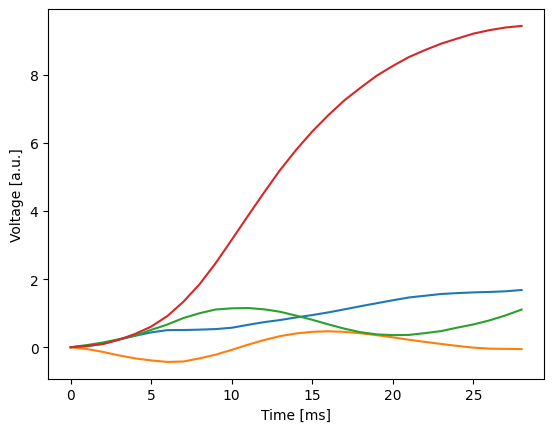

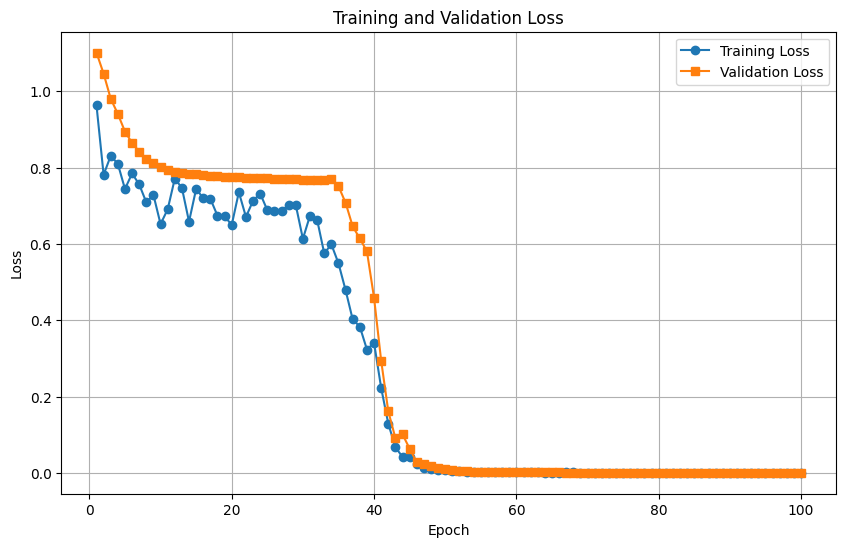

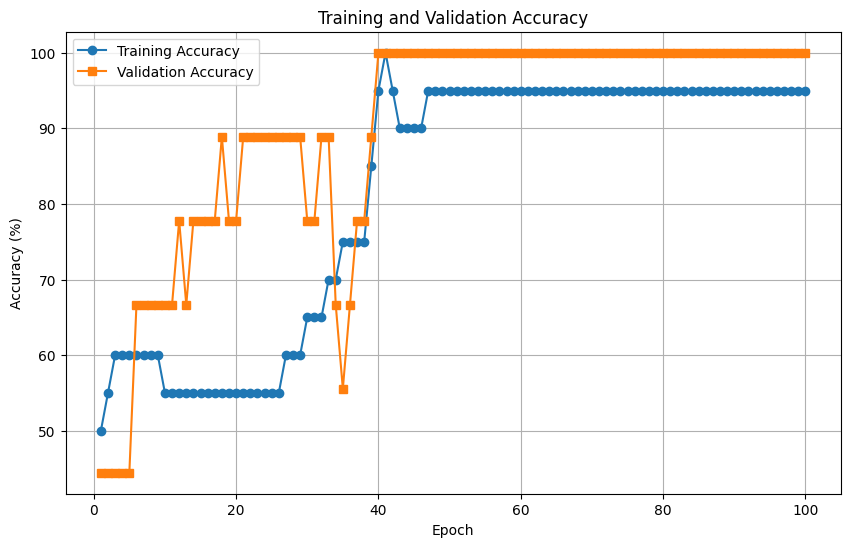

In [57]:
trained_snn = model.snn.cpu()  # Modell auf CPU verschieben
frames_cpu = frames.to("cpu")  # Eingabedaten ebenfalls auf CPU verschieben

trained_readout_voltages = trained_snn(frames_cpu[:, :1])

plt.plot(trained_readout_voltages.squeeze(1).cpu().detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

# Plot für Trainings- und Validierungsverlust
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_losses) + 1), mean_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot für Trainings- und Validierungsgenauigkeit
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, label="Training Accuracy", marker="o")
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label="Validation Accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# eine Minute

---